Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

0
0


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        image_size=(img_height,img_width),
        seed=123,
        validation_split=0.2,
        subset = "training",
        batch_size = batch_size)

Found 15748 files belonging to 9 classes.
Using 12599 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height,img_width),
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    batch_size = batch_size)

Found 15748 files belonging to 9 classes.
Using 3149 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

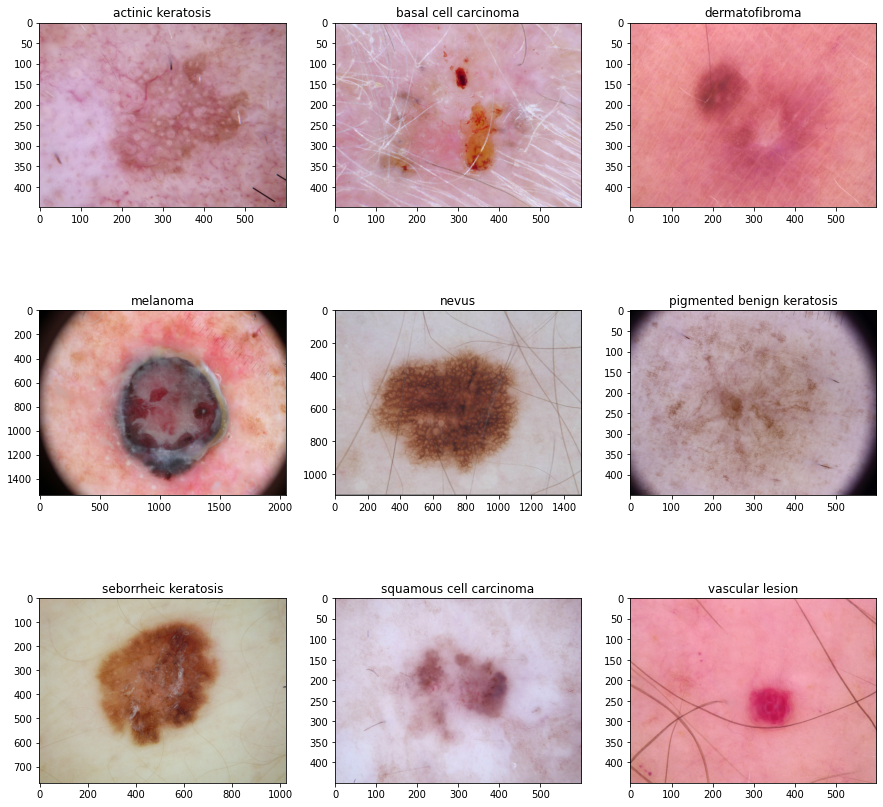

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(15,15))
for index in range(9): 
  plt.subplot(3, 3, index + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[index]+'/*.jpg'))[0]))
  plt.title(class_names[index])
  plt.imshow(image)



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

total_class = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape= (img_height,img_width,3))])

model.add(Conv2D(16,3,padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,3,padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,3,padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dense(total_class))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 [==============================] - 1146s 595ms/step - loss: 1.6447 - accuracy: 0.3669 - val_loss: 1.2367 - val_accuracy: 0.5272
Epoch 2/20
394/394 [==============================] - 8s 21ms/step - loss: 1.0832 - accuracy: 0.5981 - val_loss: 0.8871 - val_accuracy: 0.6634
Epoch 3/20
394/394 [==============================] - 8s 21ms/step - loss: 0.7594 - accuracy: 0.7163 - val_loss: 0.7528 - val_accuracy: 0.6967
Epoch 4/20
394/394 [==============================] - 8s 21ms/step - loss: 0.5016 - accuracy: 0.8201 - val_loss: 0.4682 - val_accuracy: 0.8266
Epoch 5/20
394/394 [==============================] - 8s 21ms/step - loss: 0.3849 - accuracy: 0.8591 - val_loss: 0.4152 - val_accuracy: 0.8485
Epoch 6/20
394/394 [==============================] - 8s 21ms/step - loss: 0.2686 - accuracy: 0.9003 - val_loss: 0.3511 - val_accuracy: 0.8781
Epoch 7/20
394/394 [==============================] - 8s 21ms/step - loss: 0.2382 - accuracy: 0.9097 - val_loss: 0.3171 - val_accuracy: 0.

### Visualizing training results

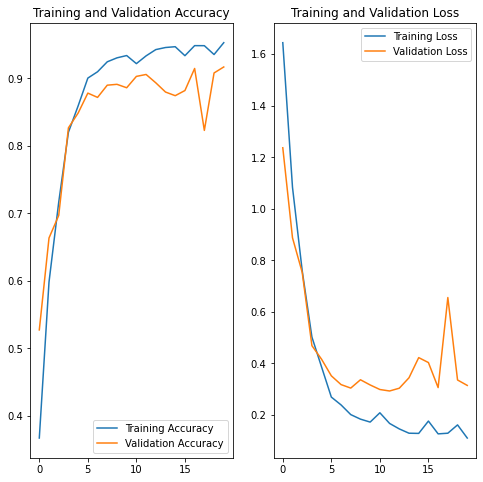

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
- The model is overfitting since the accuracy of the model on the training and the validation is significantly high and can be apparenlty observed at 20th epoch
- Another evidence is the class imabalance, since there are few classes with less number of images, the model would have not leared to its full potential. This issue can be overcome using the concept of data augmentation

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([
                                       layers.experimental.preprocessing.RandomFlip("horizontal",
                                                                                    input_shape=(img_height,img_width,3)),
                                       layers.experimental.preprocessing.RandomRotation(0.2),
                                       layers.experimental.preprocessing.RandomZoom(0.2)
]
)

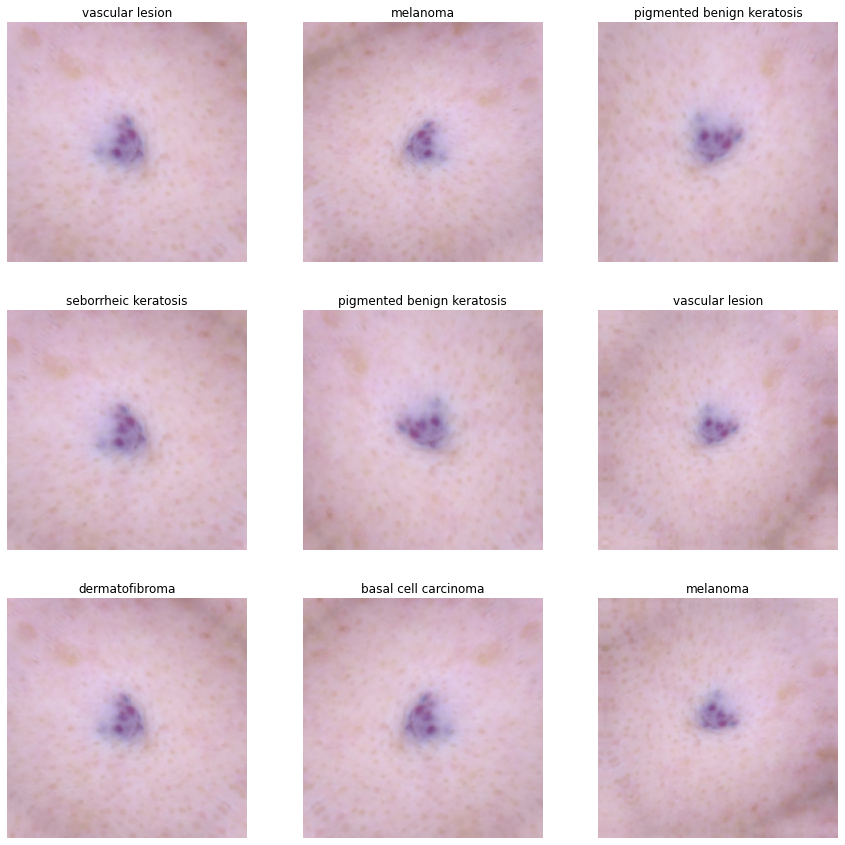

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(15, 15))
for image, labels in train_ds.take(1):
    for index in range(9):
      augmented_image = data_augmentation(image)
      ax = plt.subplot(3, 3, index + 1)
      plt.imshow(augmented_image[0].numpy().astype("uint8"))
      plt.title(class_names[labels[index]])
      plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, img_width,3))])


model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape= (img_height,img_width,3)))
model.add(Conv2D(16,3,padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,3,padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,3,padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dense(total_class))

### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
394/394 [==============================] - 9s 22ms/step - loss: 1.7578 - accuracy: 0.3176 - val_loss: 1.4033 - val_accuracy: 0.4544
Epoch 2/20
394/394 [==============================] - 8s 22ms/step - loss: 1.2588 - accuracy: 0.5150 - val_loss: 1.1721 - val_accuracy: 0.5580
Epoch 3/20
394/394 [==============================] - 9s 22ms/step - loss: 1.0271 - accuracy: 0.6126 - val_loss: 0.9469 - val_accuracy: 0.6405
Epoch 4/20
394/394 [==============================] - 8s 22ms/step - loss: 0.8328 - accuracy: 0.6918 - val_loss: 0.7970 - val_accuracy: 0.7082
Epoch 5/20
394/394 [==============================] - 8s 22ms/step - loss: 0.6764 - accuracy: 0.7516 - val_loss: 0.7771 - val_accuracy: 0.7212
Epoch 6/20
394/394 [==============================] - 8s 22ms/step - loss: 0.5403 - accuracy: 0.8032 - val_loss: 0.6367 - val_accuracy: 0.7701
Epoch 7/20
394/394 [==============================] - 9s 22ms/step - loss: 0.4771 - accuracy: 0.8298 - val_loss: 0.5232 - val_accuracy: 0.8152

### Visualizing the results

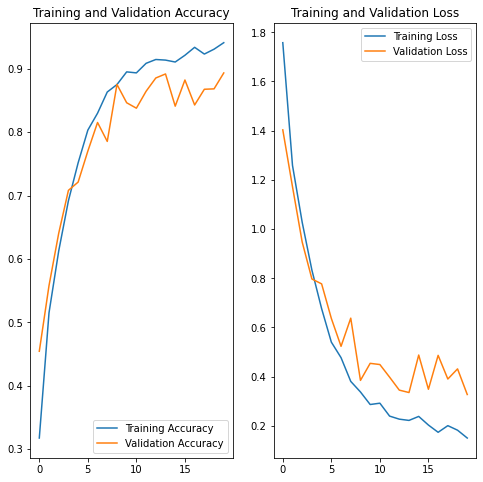

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- Compared to the previous model, after data augmentation, the validation accuracy of the model has been increased, indicating the reduction in the overfit of the model. However, the model can be further improved

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.
classes = {}
for label in class_names:
  classes[label] = len(list(data_dir_train.glob(label+'/*.jpg')))

classes

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 447,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

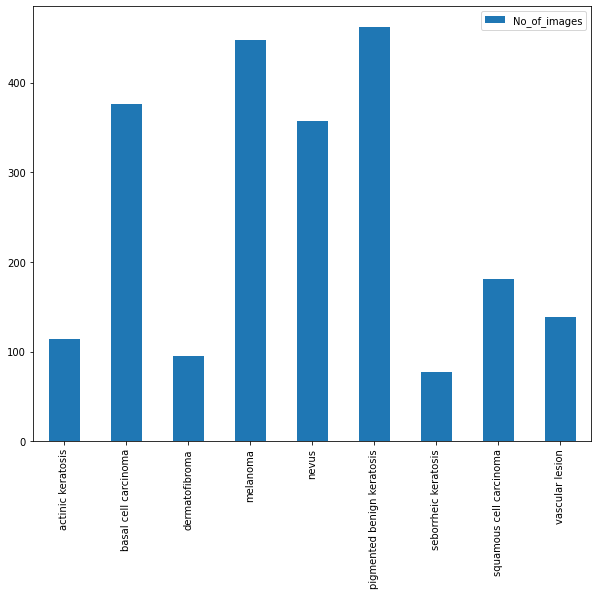

In [24]:
classes_df = pd.DataFrame(classes.items(),columns = ['Labels', 'No_of_images'],index = list(classes))
classes_df.plot.bar(figsize = (10,8))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? - Seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples? - pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="/content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA23D0ECED0>: 100%|██████████| 500/500 [00:18<00:00, 27.55 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA23D116D90>: 100%|██████████| 500/500 [00:18<00:00, 27.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA23D0DFE50>: 100%|██████████| 500/500 [00:17<00:00, 27.96 Samples/s]


Initialised with 447 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FA23D09EB50>: 100%|██████████| 500/500 [01:35<00:00,  5.23 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA23D0DFFD0>: 100%|██████████| 500/500 [01:24<00:00,  5.89 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA23D09AB50>: 100%|██████████| 500/500 [00:18<00:00, 27.49 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA23D0D8710>: 100%|██████████| 500/500 [00:41<00:00, 11.94 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA2C039EF90>: 100%|██████████| 500/500 [00:17<00:00, 28.66 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA23D0D5050>: 100%|██████████| 500/500 [00:18<00:00, 27.66 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

18000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_3d04fabe-0cbd-4d19-9a7c-e339b619e78a.jpg',
 '/content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_496ff022-af3a-4694-9efb-42bce81490a2.jpg',
 '/content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_99e66c13-2e3b-422a-94e3-9696e7dc3862.jpg',
 '/content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_46a2eaf5-9314-4b2e-a6c7-23354298061c.jpg',
 '/content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin 

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new [:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [30]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
new_df = df2

In [32]:
new_df['Label'].value_counts()

melanoma                      2000
squamous cell carcinoma       2000
actinic keratosis             2000
basal cell carcinoma          2000
nevus                         2000
pigmented benign keratosis    2000
vascular lesion               2000
seborrheic keratosis          2000
dermatofibroma                2000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
data_dir_train="/content/drive/MyDrive/CNN_assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20248 files belonging to 9 classes.
Using 16199 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20248 files belonging to 9 classes.
Using 4049 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
## your code goes here
model = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, img_width,3))])


model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape= (img_height,img_width,3)))
model.add(Conv2D(16,3,padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32,3,padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,3,padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dense(total_class))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
## your code goes here
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [38]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/30
507/507 [==============================] - 88s 169ms/step - loss: 1.9158 - accuracy: 0.2430 - val_loss: 1.7761 - val_accuracy: 0.3213
Epoch 2/30
507/507 [==============================] - 78s 151ms/step - loss: 1.5150 - accuracy: 0.4106 - val_loss: 1.4357 - val_accuracy: 0.4890
Epoch 3/30
507/507 [==============================] - 81s 158ms/step - loss: 1.2963 - accuracy: 0.5007 - val_loss: 1.2776 - val_accuracy: 0.5177
Epoch 4/30
507/507 [==============================] - 79s 154ms/step - loss: 1.1731 - accuracy: 0.5511 - val_loss: 1.3078 - val_accuracy: 0.5162
Epoch 5/30
507/507 [==============================] - 78s 152ms/step - loss: 1.0687 - accuracy: 0.5961 - val_loss: 1.0521 - val_accuracy: 0.5937
Epoch 6/30
507/507 [==============================] - 78s 151ms/step - loss: 0.9379 - accuracy: 0.6549 - val_loss: 0.9418 - val_accuracy: 0.6419
Epoch 7/30
507/507 [==============================] - 77s 151ms/step - loss: 0.8376 - accuracy: 0.6884 - val_loss: 0.8750 - val_ac

#### **Todo:**  Visualize the model results

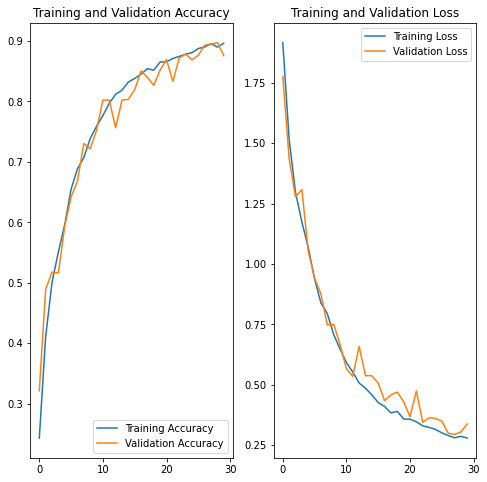

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Yes, from the analysis of the plot and the logs from epoch, the accuracy difference between the train and validation data is close. Hence, it can be considered that the issue of overfitting of the model is resolved by the class rebalance technique


In [40]:
# Evaluating the model on the test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_test,
        image_size=(img_height,img_width),
        seed=123,
        batch_size = batch_size)

Found 118 files belonging to 9 classes.


In [41]:
test_ds_result = model.evaluate(test_ds)
print("Test loss: {:.4f}".format(test_ds_result[0]))
print("Test accuracy: {:.4f}".format(test_ds_result[1]))


4/4 [==============================] - 25s 71ms/step - loss: 7.2635 - accuracy: 0.3475
Test loss: 7.2635
Test accuracy: 0.3475
